# Analytics Vidhya - Game of Deep Learning || Computer Vision Hackathon
 - Competition Link: https://datahack.analyticsvidhya.com/contest/game-of-deep-learning/

# Problem Statement
Ship or vessel detection has a wide range of applications, in the areas of maritime safety, fisheries management, marine pollution, defence and maritime security, protection from piracy, illegal migration, etc.

Keeping this in mind, a Governmental Maritime and Coastguard Agency is planning to deploy a computer vision based automated system to identify ship type only from the images taken by the survey boats. You have been hired as a consultant to build an efficient model for this project.

There are 5 classes of ships to be detected which are as follows:

* Cargo
* Military
* Carrier
* Cruise
* Tankers


![](https://datahack.analyticsvidhya.com/media/__sized__/contest_cover/god_2-thumbnail-1200x1200-90.jpg)

# Approach
 - Created a Custom Pytorch Data loader function
 - Used Pytorch Pretrained Models
 - Used Resnet50, Resnet152 and Resnet101
 - Final Submission is result of votings based on 3 submission files created from 3 different models:
     - Image size 224x224
     - Data Augmenation
     - Stratified Sampling split for training and validation data because of data imbalance
     - Pre-trained network(resnet50, Resnet152 and Resnet101) - Unfreezed All Layers
     - Saved the best model with good accuracy and used that to make predictions

# Import Libraries

In [1]:
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
import pandas as pd
import os
from PIL import Image
import shutil
import torchvision
import numpy as np
import os.path
from sklearn.model_selection import train_test_split
import cv2
import random

In [2]:
#define the transformations
transform_ship = transforms.Compose([transforms.ToTensor()])

In [3]:
SEED = 200
base_dir = '../input/'

def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(SEED)

# Custom class for loading data


In [4]:
#read the train csv

train_data = pd.read_csv(base_dir+'/train/train.csv')

In [5]:
train_data.head()

image  category
0  2823080.jpg         1
1  2870024.jpg         1
2  2662125.jpg         2
3  2900420.jpg         3
4  2804883.jpg         2

In [6]:
### map imge names to labels
map_img_class_dict = {k:v for k, v in zip(train_data.image, train_data.category)}

In [7]:
#read the test csv

test_data = pd.read_csv(base_dir+'/test_ApKoW4T.csv')
test_data.head()

image
0  1007700.jpg
1  1011369.jpg
2  1051155.jpg
3  1062001.jpg
4  1069397.jpg

In [8]:
from PIL import Image

class ShipDataLoader(torch.utils.data.DataLoader):
    def __init__(self, CSVfolder, process='train', transform = transforms.Compose([transforms.Resize(size=(224, 224)),transforms.ToTensor()]), imgFolder='../input/train/images/',labelsDict = {}, y_labels = list(train_data.category)):
        
        self.process = process
        self.imgFolder = imgFolder
        self.CSVfolder = CSVfolder
        self.y = y_labels
        self.FileList = pd.read_csv(self.CSVfolder)['image'].tolist()
        self.transform = transform
        self.labelsDict = labelsDict
        
        if self.process =='train':
            self.labels = [labelsDict[i] for i in self.FileList]
        else:
            self.labels = [0 for i in range(len(self.FileList))]

    def __len__(self):
        return len(self.FileList)
    
    def __getitem__(self,idx):
        file_name =  self.FileList[idx]
        image_data=self.pil_loader(self.imgFolder+"/"+file_name)
        
        if self.transform:
            image_data = self.transform(image_data)
        
        if self.process == 'train':
            label = self.y[idx]
        else:
            label = file_name
            
        return image_data, label
    
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

In [9]:
#define the batchsize
training_batchsize = 5

In [10]:
#retrieve the full data
full_data = ShipDataLoader(base_dir+'/train/train.csv',process = "train", imgFolder = base_dir+"/train/images", labelsDict = map_img_class_dict)

In [11]:
#create a dataloader
trainfull_loader = torch.utils.data.DataLoader(full_data, batch_size=training_batchsize, shuffle=True)

# Visualization of Data

In [12]:
# dictionary ship encoding 
ship = {1: 'Cargo', 
        2: 'Military', 
        3: 'Carrier', 
        4: 'Cruise', 
        5: 'Tankers'}

In [13]:
#custom function to display images

def imshow(img, title):
    
    #convert image from tensor to numpy for visualization
    npimg = img.numpy()
    #define the size of a figure
    plt.figure(figsize = (15, 15))
    plt.axis("off")
    
    #interchaging the image sizes - transposing
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title, fontsize=15)
    plt.show()

In [14]:
#function to get images and feed into our custom function 'imshow'

def show_batch_images(dataloader):
    
    #getting the images
    images, labels = next(iter(dataloader))
    #make a grid from those images
    img = torchvision.utils.make_grid(images)
    imshow(img, "classes: " + str([str(x.item())+ " "+ ship[x.item()] for x in labels]))

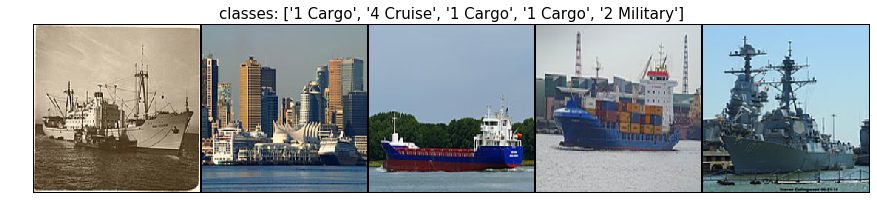

In [15]:
show_batch_images(trainfull_loader)

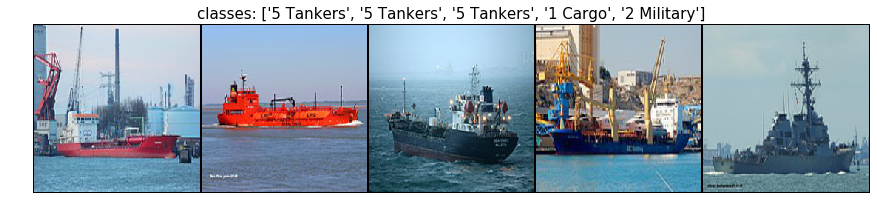

In [16]:
show_batch_images(trainfull_loader)

# Modeling

In [17]:
#checking for available gpu

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

from torchvision import models
import torch.optim as optim

#define the number of classes for the final layer
num_classes = 5

cuda:0


### Data Augmentation

A common strategy for training neural networks is to introduce randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc.

To randomly rotate, scale and crop, then flip your images you would define your transforms like this:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
```

You'll also typically want to normalize images with `transforms.Normalize`. You pass in a list of means and list of standard deviations, then the color channels are normalized like so

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Subtracting `mean` centers the data around zero and dividing by `std` squishes the values to be between -1 and 1. Normalizing helps keep the network work weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

You can find a list of all [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html). When you're testing however, you'll want to use images that aren't altered (except you'll need to normalize the same way). So, for validation/test images, you'll typically just resize and crop.

In [18]:
Training_transforms = transforms.Compose([
	transforms.Resize((224,224)),
	transforms.RandomHorizontalFlip(),
	transforms.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1, hue=0.1),
	transforms.RandomAffine(degrees=15, translate=(0.3,0.3), scale=(0.5,1.5), shear=None, resample=False, fillcolor=0),
	transforms.ToTensor(),
	transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [19]:
validation_transforms = transforms.Compose([
	transforms.Resize((224,224)),
	transforms.RandomHorizontalFlip(),
	transforms.ToTensor(),
	transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
		])

In [20]:
from torch.utils.data.sampler import SubsetRandomSampler

In [21]:
#### 90-10 train-validation split
tr, val = train_test_split(train_data.category, stratify=train_data.category, test_size=0.15, random_state=10)

### Batchsize and parallelize

training_batchsize = 16
num_workers = 8

#### Idx for train and valid
train_sampler = SubsetRandomSampler(list(tr.index)) 
valid_sampler = SubsetRandomSampler(list(val.index))

In [22]:
len(list(tr.index))

5314

In [23]:
len(list(val.index))

938

In [24]:
#### Train dataloader ####
traindataset = ShipDataLoader('../input/train/train.csv',"train", Training_transforms, '../input/train/images', map_img_class_dict)
train_loader = torch.utils.data.DataLoader(traindataset, batch_size= training_batchsize ,sampler=train_sampler,num_workers=num_workers)

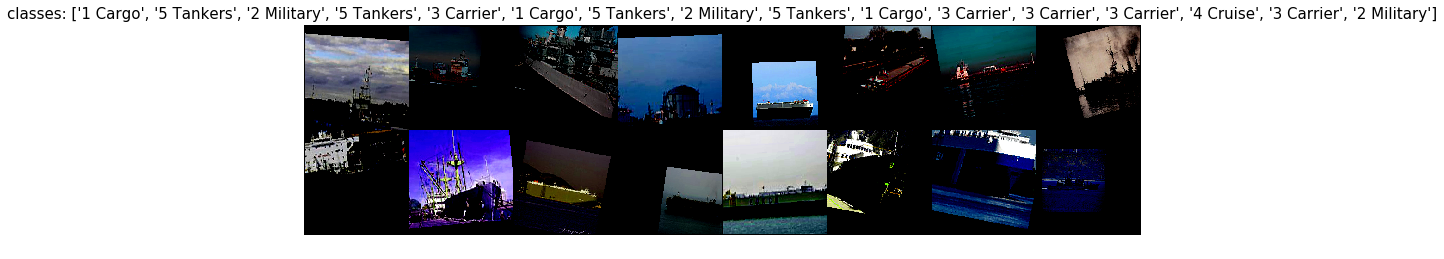

In [25]:
show_batch_images(train_loader)

In [26]:
#### Valid dataloader ####

valdataset = ShipDataLoader('../input/train/train.csv',"train", validation_transforms, '../input/train/images', map_img_class_dict)
val_loader = torch.utils.data.DataLoader(valdataset, batch_size=training_batchsize,sampler=valid_sampler,num_workers=num_workers)

In [27]:
#### Test dataloader ####

testdataset = ShipDataLoader('../input/train/train.csv',"test", validation_transforms, '../input/train/images', map_img_class_dict)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=training_batchsize,num_workers=num_workers)

In [28]:
import torch.nn as nn
import copy

In [29]:
#create a iterator

dataiter = iter(train_loader)
images, labels = dataiter.next()

#shape of images bunch
print(images.shape)

#shape of first image in a group of 4
print(images[1].shape)

#class label for first image
print(labels[1])


torch.Size([16, 3, 224, 224])
torch.Size([3, 224, 224])
tensor(2)


In [30]:
num_classes

5

In [31]:
dataloaders = {"train": train_loader, "val": val_loader} 
dataset_sizes = {"train": len(list(tr.index)), "val": len(list(val.index))}

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, test_losses = [], []
    train_acc, test_acc = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device) - 1

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == "train":
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
            elif phase == "val":
                test_losses.append(epoch_loss)
                test_acc.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    
    del inputs, labels
    torch.cuda.empty_cache()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #saving the best model
    torch.save(model.state_dict(best_model_wts),"saved.pth")
    print("best model saved")
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, test_losses, train_acc, test_acc

In [33]:
def make_predictions(dataloader, trained_model):

    pred = dict()
    trained_model.eval()

    for  data in dataloader:
        images, labels = data
        images = images.cuda()
        
        #push model to cuda
        trained_model.cuda()
        outputs = trained_model(images)
        
        #print(outputs)
        for i in range(len(images)):
            #print(torch.argmax(outputs[i]))
            detect_class = torch.argmax(outputs[i]).item() + 1
            pred[labels[i]] = detect_class   

    df = pd.DataFrame(list(pred.items()), columns=['image', 'category'])
    return(df)

In [34]:
import time

# Resnet 50 Model

In [35]:
model_ft = models.resnet50(pretrained = True)

print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 69772309.52it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [36]:
#number of trainable parameters in resent101 - before freezing

print("Number of trainable parameters: ", sum(p.numel() for p in model_ft.parameters() if p.requires_grad))

Number of trainable parameters:  25557032


In [37]:
### Let's print the names of the layer stacks for our model
for name, child in model_ft.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [38]:
model_ft.fc.in_features

2048

In [39]:
# Parameters of newly constructed modules have requires_grad=True by default
fc = nn.Sequential(nn.Linear(model_ft.fc.in_features, 720),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(720, 256),
                                nn.ReLU(),
                                nn.Dropout(0.4),
                                nn.Linear(256, 64),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(64, 5),
                                nn.Softmax(dim = 1))

In [40]:
model_ft.fc = fc

In [41]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [42]:
criterion = nn.CrossEntropyLoss()

model_ft = model_ft.to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.0001, weight_decay=1e-3)

# Decay LR by a factor of 0.15 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.15)

scheduler_cosineAL = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, len(train_loader), eta_min=1e-6)

# Training Resnet50 Model

In [43]:
model_trained, train_lr, test_lr,train_acc, test_acc = train_model(model_ft, criterion, optimizer_ft, scheduler_cosineAL, num_epochs=80)

Epoch 0/79
----------
train Loss: 1.4006 Acc: 0.4825
val Loss: 1.1933 Acc: 0.6898
Epoch 1/79
----------
train Loss: 1.2320 Acc: 0.6735
val Loss: 1.1236 Acc: 0.7814
Epoch 2/79
----------
train Loss: 1.1882 Acc: 0.7211
val Loss: 1.1901 Acc: 0.7058
Epoch 3/79
----------
train Loss: 1.1458 Acc: 0.7610
val Loss: 1.1051 Acc: 0.7964
Epoch 4/79
----------
train Loss: 1.1465 Acc: 0.7589
val Loss: 1.0898 Acc: 0.8145
Epoch 5/79
----------
train Loss: 1.1779 Acc: 0.7275
val Loss: 1.0691 Acc: 0.8358
Epoch 6/79
----------
train Loss: 1.1463 Acc: 0.7599
val Loss: 1.0777 Acc: 0.8241
Epoch 7/79
----------
train Loss: 1.1302 Acc: 0.7768
val Loss: 1.0664 Acc: 0.8369
Epoch 8/79
----------
train Loss: 1.1213 Acc: 0.7843
val Loss: 1.0658 Acc: 0.8390
Epoch 9/79
----------
train Loss: 1.1068 Acc: 0.7990
val Loss: 1.0250 Acc: 0.8763
Epoch 10/79
----------
train Loss: 1.1093 Acc: 0.7971
val Loss: 1.1101 Acc: 0.7921
Epoch 11/79
----------
train Loss: 1.1251 Acc: 0.7802
val Loss: 1.0428 Acc: 0.8614
Epoch 12/79
--

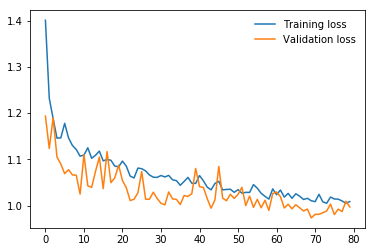

In [44]:
#plot the losses

plt.plot(train_lr, label='Training loss')
plt.plot(test_lr, label='Validation loss')
plt.legend(frameon=False)
plt.show()

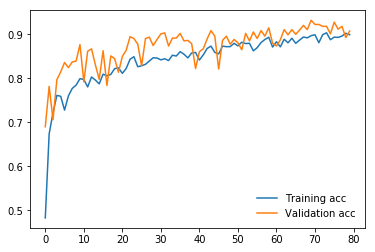

In [45]:
plt.plot(train_acc, label = "Training acc")
plt.plot(test_acc, label = "Validation acc")
plt.legend(frameon=False)
plt.show()

# Making Predictions - Resnet50

In [46]:
test_df_res50 = make_predictions(test_loader, model_trained)

In [47]:
test_df_res50.rename(columns = {'category':'rs50_category'}, inplace = True) 
test_df_res50.head()

image  rs50_category
0  2823080.jpg              1
1  2870024.jpg              1
2  2662125.jpg              2
3  2900420.jpg              3
4  2804883.jpg              2

In [48]:
test_df_res50.rs50_category.value_counts()

1    2342
2    1119
5    1009
3     939
4     843
Name: rs50_category, dtype: int64

# Resnet 101 Model

In [49]:
model_ft = models.resnet101(pretrained = True)

print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /tmp/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:02<00:00, 75822825.21it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [50]:
#number of trainable parameters in resent101 - before freezing

print("Number of trainable parameters: ", sum(p.numel() for p in model_ft.parameters() if p.requires_grad))

Number of trainable parameters:  44549160


In [51]:
### Let's print the names of the layer stacks for our model
for name, child in model_ft.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [52]:
model_ft.fc.in_features

2048

In [53]:
# Parameters of newly constructed modules have requires_grad=True by default
fc = nn.Sequential(nn.Linear(model_ft.fc.in_features, 720),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(720, 256),
                                nn.ReLU(),
                                nn.Dropout(0.4),
                                nn.Linear(256, 64),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(64, 5),
                                nn.Softmax(dim = 1))

In [54]:
model_ft.fc = fc

In [55]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [56]:
criterion = nn.CrossEntropyLoss()

model_ft = model_ft.to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.0001, weight_decay=1e-3)

scheduler_cosineAL = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, len(train_loader), eta_min=1e-6)

# Training Resnet101 Model

In [57]:
model_trained, train_lr, test_lr,train_acc, test_acc = train_model(model_ft, criterion, optimizer_ft, scheduler_cosineAL, num_epochs=80)

Epoch 0/79
----------
train Loss: 1.4375 Acc: 0.4492
val Loss: 1.5168 Acc: 0.3390
Epoch 1/79
----------
train Loss: 1.3279 Acc: 0.5702
val Loss: 1.3128 Acc: 0.5778
Epoch 2/79
----------
train Loss: 1.2903 Acc: 0.6139
val Loss: 1.2040 Acc: 0.6919
Epoch 3/79
----------
train Loss: 1.2649 Acc: 0.6357
val Loss: 1.2158 Acc: 0.6812
Epoch 4/79
----------
train Loss: 1.2329 Acc: 0.6615
val Loss: 1.3024 Acc: 0.5896
Epoch 5/79
----------
train Loss: 1.2264 Acc: 0.6643
val Loss: 1.2293 Acc: 0.6535
Epoch 6/79
----------
train Loss: 1.2038 Acc: 0.6998
val Loss: 1.1795 Acc: 0.7217
Epoch 7/79
----------
train Loss: 1.1979 Acc: 0.7091
val Loss: 1.1537 Acc: 0.7473
Epoch 8/79
----------
train Loss: 1.2164 Acc: 0.6886
val Loss: 1.1328 Acc: 0.7687
Epoch 9/79
----------
train Loss: 1.1852 Acc: 0.7222
val Loss: 1.0880 Acc: 0.8156
Epoch 10/79
----------
train Loss: 1.1724 Acc: 0.7324
val Loss: 1.0977 Acc: 0.8060
Epoch 11/79
----------
train Loss: 1.1596 Acc: 0.7480
val Loss: 1.0940 Acc: 0.8060
Epoch 12/79
--

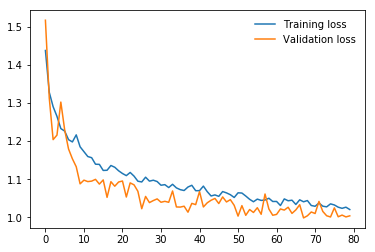

In [58]:
#plot the losses

plt.plot(train_lr, label='Training loss')
plt.plot(test_lr, label='Validation loss')
plt.legend(frameon=False)
plt.show()

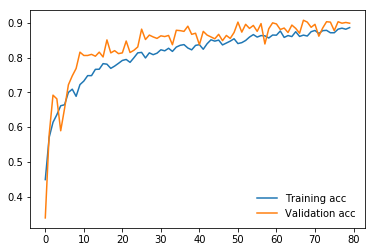

In [59]:
plt.plot(train_acc, label = "Training acc")
plt.plot(test_acc, label = "Validation acc")
plt.legend(frameon=False)
plt.show()

# Making Predictions - Resnet101

In [60]:
test_df_res101 = make_predictions(test_loader, model_trained)

In [61]:
test_df_res101.rename(columns = {'category':'rs101_category'}, inplace = True) 

test_df_res101.head()

image  rs101_category
0  2823080.jpg               1
1  2870024.jpg               1
2  2662125.jpg               2
3  2900420.jpg               3
4  2804883.jpg               2

In [62]:
test_df_res101.rs101_category.value_counts()

1    2213
5    1164
2    1143
3     933
4     799
Name: rs101_category, dtype: int64

# resnet152 Model

In [63]:
model_ft = models.resnet152(pretrained = True)

print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 97142832.93it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [64]:
#number of trainable parameters in resent101 - before freezing

print("Number of trainable parameters: ", sum(p.numel() for p in model_ft.parameters() if p.requires_grad))

Number of trainable parameters:  60192808


In [65]:
### Let's print the names of the layer stacks for our model
for name, child in model_ft.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [66]:
model_ft.fc.in_features

2048

In [67]:
# Parameters of newly constructed modules have requires_grad=True by default
fc = nn.Sequential(nn.Linear(model_ft.fc.in_features, 720),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(720, 256),
                                nn.ReLU(),
                                nn.Dropout(0.4),
                                nn.Linear(256, 64),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(64, 5),
                                nn.Softmax(dim = 1))

In [68]:
model_ft.fc = fc

In [69]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [70]:
criterion = nn.CrossEntropyLoss()

model_ft = model_ft.to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.0001, weight_decay=1e-3)

scheduler_cosineAL = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, len(train_loader), eta_min=1e-6)

 # Training resnet152 Model

In [71]:
model_trained, train_lr, test_lr,train_acc, test_acc = train_model(model_ft, criterion, optimizer_ft, scheduler_cosineAL, num_epochs=80)

Epoch 0/79
----------
train Loss: 1.4544 Acc: 0.4138
val Loss: 1.3626 Acc: 0.5458
Epoch 1/79
----------
train Loss: 1.3485 Acc: 0.5514
val Loss: 1.4968 Acc: 0.3827
Epoch 2/79
----------
train Loss: 1.3191 Acc: 0.5809
val Loss: 1.2837 Acc: 0.6077
Epoch 3/79
----------
train Loss: 1.2751 Acc: 0.6263
val Loss: 1.2524 Acc: 0.6375
Epoch 4/79
----------
train Loss: 1.2608 Acc: 0.6479
val Loss: 1.2806 Acc: 0.6173
Epoch 5/79
----------
train Loss: 1.2116 Acc: 0.6976
val Loss: 1.1285 Acc: 0.7772
Epoch 6/79
----------
train Loss: 1.1935 Acc: 0.7117
val Loss: 1.1141 Acc: 0.7878
Epoch 7/79
----------
train Loss: 1.1737 Acc: 0.7320
val Loss: 1.1794 Acc: 0.7228
Epoch 8/79
----------
train Loss: 1.1840 Acc: 0.7209
val Loss: 1.0744 Acc: 0.8305
Epoch 9/79
----------
train Loss: 1.1700 Acc: 0.7365
val Loss: 1.0713 Acc: 0.8305
Epoch 10/79
----------
train Loss: 1.1603 Acc: 0.7431
val Loss: 1.2172 Acc: 0.6908
Epoch 11/79
----------
train Loss: 1.1448 Acc: 0.7614
val Loss: 1.0788 Acc: 0.8220
Epoch 12/79
--

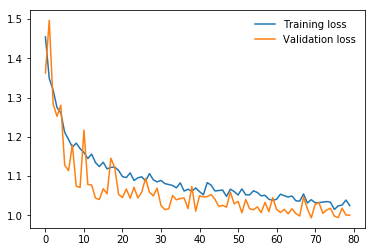

In [72]:
#plot the losses

plt.plot(train_lr, label='Training loss')
plt.plot(test_lr, label='Validation loss')
plt.legend(frameon=False)
plt.show()

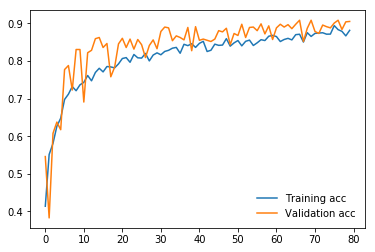

In [73]:
plt.plot(train_acc, label = "Training acc")
plt.plot(test_acc, label = "Validation acc")
plt.legend(frameon=False)
plt.show()

# Making Predictions - resnet152

In [74]:
test_df_res152 = make_predictions(test_loader, model_trained)

In [75]:
test_df_res152.rename(columns = {'category':'res152_category'}, inplace = True) 

test_df_res152.head()

image  res152_category
0  2823080.jpg                1
1  2870024.jpg                1
2  2662125.jpg                2
3  2900420.jpg                3
4  2804883.jpg                2

In [76]:
test_df_res152.res152_category.value_counts()

1    2009
5    1366
2    1177
3     902
4     798
Name: res152_category, dtype: int64

# Merge Results

In [77]:
merge_results = [df.set_index(['image']) for df in [test_df_res50, test_df_res101, test_df_res152]]
merge_results = pd.concat(merge_results, axis=1).reset_index()

In [78]:
merge_results.head()

image  rs50_category  rs101_category  res152_category
0  2823080.jpg              1               1                1
1  2870024.jpg              1               1                1
2  2662125.jpg              2               2                2
3  2900420.jpg              3               3                3
4  2804883.jpg              2               2                2

In [79]:
merged_pred = merge_results.drop("image", axis = 1)

#finding the most frequent value in a row
merged_pred = merged_pred.mode(axis = 1)[0]

In [80]:
final_df = pd.DataFrame({"image": list(merge_results.image)})
final_df["category"] = merged_pred

In [81]:
final_df.head()

image  category
0  2823080.jpg       1.0
1  2870024.jpg       1.0
2  2662125.jpg       2.0
3  2900420.jpg       3.0
4  2804883.jpg       2.0

In [82]:
final_df.to_csv("final_submission.csv")